In [1]:
import datetime
import gc
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from ipynb.fs.defs.data_pipeline import EXPORTED as data_pipeline
from tensorflow import keras

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

del gpus

1 Physical GPUs, 1 Logical GPUs


# Loading builders for datasets

In [3]:
RECIPES5K_DIR = "../Food Datasets/final-dataset/tfrecord/recipes5k/1.0.0"
FOOD101_DIR = "../Food Datasets/final-dataset/tfrecord/food101/1.0.1"
NUTRITION5K_DIR = "../Food Datasets/final-dataset/tfrecord/nutrition5k/1.0.0"


recipes5k_food101_builder = tfds.builder_from_directories([RECIPES5K_DIR, FOOD101_DIR])
nutrition5k_builder = tfds.builder_from_directory(NUTRITION5K_DIR)

In [4]:
recipes5k_food101_builder.info.splits["train"].num_examples

105826

In [5]:
nutrition5k_builder.info.splits["train"].num_examples

271407

In [6]:
def encode_category_ingredients(category_tensor, ingredients_tensor):
    category = str(category_tensor.numpy(), "utf-8")
    ingredients = str(ingredients_tensor.numpy(), "utf-8")
    one_hot_category_tensor = (
        data_pipeline.one_hot_encoder.get_category_one_hot_encoding(category)
    )
    one_hot_ingredients_tensor = (
        data_pipeline.one_hot_encoder.get_ingredients_one_hot_encoding(
            ingredients.split(",")
        )
    )
    return (
        tf.constant(one_hot_category_tensor, dtype=tf.uint8),
        tf.constant(one_hot_ingredients_tensor, dtype=tf.uint8),
    )

In [7]:
def parse_function(x):
    encoded = tf.py_function(
        encode_category_ingredients,
        [x["category"], x["ingredients"]],
        [tf.uint8, tf.uint8],
    )
    return x["image_raw"], {
        "category_output": encoded[0],
        "calorie_output": x["calorie"],
        "carbs_output": x["carbs"],
        "protein_output": x["protein"],
        "fat_output": x["fat"],
        "ingredients_output": encoded[1],
    }

## Creating dataset for training category, ingredients and nutrients

In [8]:
(
    recipes5k_food101_train,
    recipes5k_food101_validation,
    recipes5k_food101_test,
) = recipes5k_food101_builder.as_dataset(
    split=["train[:70%]", "train[70%:95%]", "train[95%:]"], shuffle_files=True
)

# Introduce the generic category, to avoid a bias dataset, only 1k images (average image per category) is taken from nutrition5k dataset
(
    nutrition5k_category_train,
    nutrition5k_category_val,
    nutrition5k_category_test,
) = nutrition5k_builder.as_dataset(
    split=["train[:700]", "train[700:950]", "train[950:1000]"], shuffle_files=True
)

train_dataset = recipes5k_food101_train.concatenate(nutrition5k_category_train)
validation_dataset = recipes5k_food101_validation.concatenate(nutrition5k_category_val)
test_dataset = recipes5k_food101_test.concatenate(nutrition5k_category_test)

In [9]:
print(f"Total training size : {train_dataset.cardinality().numpy()}")
print(f"Total validation size : {validation_dataset.cardinality().numpy()}")
print(f"Total testing size : {test_dataset.cardinality().numpy()}")

Total training size : 74778
Total validation size : 26707
Total testing size : 5341


In [10]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
validation_dataset = (
    validation_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    test_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

## Creating dataset for training ingredients and nutrients only

In [11]:
no_category_train, no_category_val, no_category_test = nutrition5k_builder.as_dataset(
    split=["train[:80%]", "train[80%:98%]", "train[98%:]"], shuffle_files=True
)

In [12]:
print(f"Total training size : {no_category_train.cardinality().numpy()}")
print(f"Total validation size : {no_category_val.cardinality().numpy()}")
print(f"Total testing size : {no_category_test.cardinality().numpy()}")

Total training size : 217126
Total validation size : 48853
Total testing size : 5428


In [13]:
no_category_train = (
    no_category_train.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
no_category_val = (
    no_category_val.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
no_category_test = (
    no_category_test.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

In [14]:
gc.collect()

0

# Model Development

In [15]:
class BaseModel:
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        self.input_shape = input_shape
        self.input_layer = self.get_input_layer()
        self.model = None
        self.name = name

    def get_input_layer(self):
        return keras.Input(shape=self.input_shape)

    def save_model(self, path):
        assert self.model is not None
        self.model.save(path, save_format="h5")

    def load_model(self, path):
        self.model = keras.models.load_model(path)

    def train_model(self, enforce_backup_empty=True, **kwargs):
        backup_dir = Path(f"./temp/backup/{self.name}")
        if enforce_backup_empty and backup_dir.exists():
            assert (
                len(list(backup_dir.iterdir())) == 0
            ), f"WARNING : THERE IS A BACKUP FILE FOR THIS MODEL : {self.name}."

        return self.model.fit(**kwargs, callbacks=self.get_callbacks())

    def get_callbacks(self):
        tensorboard_dir = f"./models/{self.name}/tensorboard/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        tensorboard_callback = keras.callbacks.TensorBoard(
            log_dir=tensorboard_dir, profile_batch=(100, 500)
        )
        backup_restore_dir = f"./temp/backup/{self.name}"
        backup_restore_callback = keras.callbacks.BackupAndRestore(
            backup_dir=backup_restore_dir
        )
        checkpoint_dir = f"./temp/checkpoint/{self.name}"
        checkpoint_file = checkpoint_dir + "/{epoch:03d}-{val_loss:.2f}.hdf5"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_file, monitor="val_loss", save_best_only=True, mode="min"
        )
        early_stopping_callback = keras.callbacks.EarlyStopping("val_loss", patience=5)
        reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=1, min_lr=0.0001
        )

        return [
            tensorboard_callback,
            early_stopping_callback,
            reduce_lr_callback,
            backup_restore_callback,
            checkpoint_callback,
        ]

## Flat Model

In [16]:
class FlatModel(BaseModel):
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        super().__init__(
            input_shape, total_food_category, total_ingredients_category, name
        )
        self.augmentation_layers = self.get_augmentation_layers()
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()
        self.shared_layers = self.get_shared_layers(self.convolution_block)

        self.category_classification_layers = self.get_category_classification_layers(
            self.shared_layers, total_food_category
        )
        self.shared_nutrition_regression_layers = self.get_shared_nutrition_layers(
            self.shared_layers
        )
        self.calorie_regression_layers = self.get_calorie_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.carbs_regression_layers = self.get_carbs_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.protein_regression_layers = self.get_protein_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.fat_regression_layers = self.get_fat_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.ingredients_multilabel_layers = self.get_ingredients_multilabel_layers(
            self.shared_layers, total_ingredients_category
        )

    def get_augmentation_layers(self):
        input_layer = keras.layers.Input(shape=self.input_shape)
        augmentation_layer = keras.layers.RandomFlip()(input_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)
        return keras.Model(
            inputs=input_layer, outputs=augmentation_layer, name="augmentation_layers"
        )

    def get_preprocess_layers(self, previous_layer):
        return None

    def get_convolution_block(self):
        return None

    def get_shared_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_layer = keras.layers.Flatten()(input_layer)
        shared_layer = keras.layers.Dense(
            2048, activation="relu", name="shared_dense_1"
        )(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        output_layer = keras.layers.Dropout(0.3)(shared_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="shared_layers"
        )

    def get_category_classification_layers(self, previous_layer, total_categories):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        category_classification_layer = keras.layers.Dense(
            total_categories, activation="softmax", name="category_output"
        )(input_layer)
        return keras.Model(
            inputs=input_layer,
            outputs=category_classification_layer,
            name="category_output",
        )

    def get_shared_nutrition_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_nutrition_regression_layers = keras.layers.Dense(
            256, activation="relu", name="nutrition_dense_1"
        )(input_layer)
        shared_nutrition_regression_layers = keras.layers.BatchNormalization()(
            shared_nutrition_regression_layers
        )
        output_layer = keras.layers.Dropout(0.2)(shared_nutrition_regression_layers)

        return keras.Model(
            inputs=input_layer,
            outputs=output_layer,
            name="nutrition_regression_shared_layers",
        )

    def get_calorie_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        calorie_regression_layers = keras.layers.Dense(1, name="calorie_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=calorie_regression_layers, name="calorie_output"
        )

    def get_carbs_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        carbs_regression_layers = keras.layers.Dense(1, name="carbs_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=carbs_regression_layers, name="carbs_output"
        )

    def get_protein_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        protein_regression_layers = keras.layers.Dense(1, name="protein_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=protein_regression_layers, name="protein_output"
        )

    def get_fat_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        fat_regression_layers = keras.layers.Dense(1, name="fat_output")(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=fat_regression_layers, name="fat_output"
        )

    def get_ingredients_multilabel_layers(self, previous_layer, total_ingredients):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        ingredients_multilabel_layers = []
        ingredients_multilabel_layers = keras.layers.Dense(
            512, activation="relu", name="ingredients_dense_1"
        )(input_layer)
        ingredients_multilabel_layers = keras.layers.BatchNormalization()(
            ingredients_multilabel_layers
        )
        ingredients_multilabel_layers = keras.layers.Dropout(0.2)(
            ingredients_multilabel_layers
        )
        output_layers = keras.layers.Dense(
            total_ingredients, activation="sigmoid", name="ingredients_output"
        )(ingredients_multilabel_layers)
        return keras.Model(
            inputs=input_layer, outputs=output_layers, name="ingredients_output"
        )

    def print_summary(self, verbose=True, include_convolution=False):
        assert (
            self.model is not None
        ), "Please run build_and_compile before printing summary."
        if verbose:
            self.augmentation_layers.summary()
            print()
            self.preprocess_layers.summary()
            print()
            if include_convolution:
                self.convolution_block.summary()
                print()
            self.shared_layers.summary()
            print()
            self.category_classification_layers.summary()
            print()
            self.shared_nutrition_regression_layers.summary()
            print()
            self.calorie_regression_layers.summary()
            print()
            self.carbs_regression_layers.summary()
            print()
            self.protein_regression_layers.summary()
            print()
            self.fat_regression_layers.summary()
            print()
            self.ingredients_multilabel_layers.summary()
            print()
        self.model.summary()

    def build_and_compile(
        self,
        lr=0.01,
        category_classification_loss=keras.losses.CategoricalCrossentropy(),
        calorie_regression_loss=keras.losses.MeanAbsoluteError(),
        carbs_regression_loss=keras.losses.MeanAbsoluteError(),
        protein_regression_loss=keras.losses.MeanAbsoluteError(),
        fat_regression_loss=keras.losses.MeanAbsoluteError(),
        ingredient_multilabel_loss=keras.losses.BinaryCrossentropy(),
        category_classification_metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
            tfa.metrics.F1Score(
                num_classes=len(data_pipeline.one_hot_encoder.all_food_categories)
            ),
        ],
        calorie_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        carbs_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        protein_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        fat_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        ingredient_multilabel_metrics=[
            keras.metrics.Precision(),
            keras.metrics.Recall(),
            tfa.metrics.F1Score(
                num_classes=len(data_pipeline.one_hot_encoder.all_ingredients)
            ),
            keras.metrics.TopKCategoricalAccuracy(1, name="Top1_Acc"),
            keras.metrics.TopKCategoricalAccuracy(5, name="Top5_Acc"),
        ],
        category_classification_loss_weights=1.0,
        ingredient_multilabel_loss_weights=1.0,
        calorie_regression_loss_weights=1.0,
        carbs_regression_loss_weights=1.0,
        protein_regression_loss_weights=1.0,
        fat_regression_loss_weights=1.0,
    ):
        assert (
            self.preprocess_layers is not None
        ), "Error: No preprocess layers exists. Class FlatModel should not be instantiated."
        assert (
            self.convolution_block is not None
        ), "Error: No convolution block exists. Class FlatModel should not be instantiated."
        model_inputs = self.input_layer
        x = self.augmentation_layers(model_inputs)
        x = self.preprocess_layers(x)
        x = self.convolution_block(x)
        x = self.shared_layers(x)
        category_classification_head = self.category_classification_layers(x)
        nutrition_regression_head = self.shared_nutrition_regression_layers(x)
        ingredients_multilabel_head = self.ingredients_multilabel_layers(x)
        calorie_regression_head = self.calorie_regression_layers(
            nutrition_regression_head
        )
        carbs_regression_head = self.carbs_regression_layers(nutrition_regression_head)
        protein_regression_head = self.protein_regression_layers(
            nutrition_regression_head
        )
        fat_regression_head = self.fat_regression_layers(nutrition_regression_head)

        model = keras.Model(
            inputs=model_inputs,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name=self.name,
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )
        self.model = model
        return model

### MobileNetv2

In [17]:
class FlatMobileNetv2Model(FlatModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "FlatFoodNet_with_MobileNetv2",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.mobilenet_v2.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        mobilenet_v2_convolution_layers.trainable = False
        return mobilenet_v2_convolution_layers

In [18]:
flat_mobilenetv2 = FlatMobileNetv2Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
)
flat_mobilenetv2.build_and_compile(lr=0.001)
flat_mobilenetv2.print_summary(verbose=False)

Model: "FlatFoodNet_with_MobileNetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation_layers (Functiona  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 preprocessing_layers (Function  (None, 224, 224, 3)  0          ['augmentation_layers[0][0]']    
 al)                                                                   

In [ ]:
keras.utils.plot_model(
    flat_mobilenetv2.model,
    "./models/flat_foodnet_mobilenetv2.png",
    show_shapes=True,
    expand_nested=False,
)

In [13]:
flat_mobilenetv2_history = flat_mobilenetv2.train_model(
    x=train_dataset, epochs=1, verbose=1, validation_data=validation_dataset
)

1654/1654 [==============================] - 943s 529ms/step - loss: 4.1607 - category_output_loss: 2.7582 - ingredients_output_loss: 0.0679 - calorie_output_loss: 0.8016 - carbs_output_loss: 0.2046 - protein_output_loss: 0.1474 - fat_output_loss: 0.1810 - category_output_categorical_accuracy: 0.3654 - category_output_precision: 0.5930 - category_output_recall: 0.2505 - ingredients_output_Ingredients_Top1_Acc: 0.0096 - ingredients_output_Ingredients_Top5_Acc: 0.1146 - calorie_output_mean_absolute_error: 0.8016 - carbs_output_mean_absolute_error: 0.2046 - protein_output_mean_absolute_error: 0.1474 - fat_output_mean_absolute_error: 0.1810 - val_loss: 3.0706 - val_category_output_loss: 2.2137 - val_ingredients_output_loss: 0.0320 - val_calorie_output_loss: 0.6367 - val_carbs_output_loss: 0.0948 - val_protein_output_loss: 0.0251 - val_fat_output_loss: 0.0682 - val_category_output_categorical_accuracy: 0.4569 - val_category_output_precision: 0.6761 - val_category_output_recall: 0.3333 - val

### ResNet50 Model

In [14]:
class FlatResNet50Model(FlatModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "FlatFoodNet_with_ResNet50",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.resnet50.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        resnet50_convolution_layers = keras.applications.ResNet50(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        resnet50_convolution_layers.trainable = False
        return resnet50_convolution_layers

In [15]:
flat_resnet50 = FlatResNet50Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
)
flat_resnet50.build_and_compile()
flat_resnet50.print_summary()

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
flat_resnet50_history = flat_resnet50.train_model(
    train_dataset, epochs=10, verbose=1, validation_data=validation_dataset
)

### EfficientNetv2 Model

In [ ]:
class FlatEfficientNetV2B0Model(FlatModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "FlatFoodNet_with_EfficientNetV2B0",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.efficientnet_v2.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        efficientnetv2b0_convolution_layers = (
            keras.applications.efficientnet_v2.EfficientNetV2B0(
                input_shape=self.input_shape, include_top=False, weights="imagenet"
            )
        )
        efficientnetv2b0_convolution_layers.trainable = False
        return efficientnetv2b0_convolution_layers

In [ ]:
flat_efficientnetv2b0 = FlatEfficientNetV2B0Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
)
flat_efficientnetv2b0.build_and_compile()
flat_efficientnetv2b0.print_summary()

In [ ]:
flat_efficientnetv2b0_history = flat_efficientnetv2b0.train_model(
    train_dataset, epochs=10, verbose=1, validation_data=validation_dataset
)

## Region Wise Model

In [13]:
class RegionWiseModel(BaseModel):
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        super().__init__(
            input_shape, total_food_category, total_ingredients_category, name
        )
        self.augmentation_layers = self.get_augmentation_layers()
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()
        self.shared_layers = self.get_shared_layers(self.convolution_block)

        self.category_classification_layers = self.get_category_classification_layers(
            self.shared_layers, total_food_category
        )
        self.shared_nutrition_regression_layers = self.get_shared_nutrition_layers(
            self.shared_layers
        )
        self.calorie_regression_layers = self.get_calorie_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.carbs_regression_layers = self.get_carbs_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.protein_regression_layers = self.get_protein_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.fat_regression_layers = self.get_fat_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.ingredients_multilabel_layers = self.get_ingredients_multilabel_layers(
            self.convolution_block, total_ingredients_category
        )

    def get_augmentation_layers(self):
        input_layer = keras.layers.Input(shape=self.input_shape)
        augmentation_layer = keras.layers.RandomFlip()(input_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)
        return keras.Model(
            inputs=input_layer, outputs=augmentation_layer, name="augmentation_layers"
        )

    def get_preprocess_layers(self, previous_layer):
        return None

    def get_convolution_block(self):
        return None

    def get_shared_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_layer = keras.layers.Flatten()(input_layer)
        shared_layer = keras.layers.Dense(
            128, activation="relu", name="shared_dense_1"
        )(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        output_layer = keras.layers.Dropout(0.2)(shared_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="shared_layers"
        )

    def get_category_classification_layers(self, previous_layer, total_categories):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        category_classification_layer = keras.layers.Dense(
            total_categories, activation="softmax", name="category_output"
        )(input_layer)
        return keras.Model(
            inputs=input_layer,
            outputs=category_classification_layer,
            name="category_output",
        )

    def get_shared_nutrition_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        nutrition_regression_layers = keras.layers.Dense(
            128, activation="relu", name="nutrition_dense_1"
        )(input_layer)
        nutrition_regression_layers = keras.layers.BatchNormalization()(
            nutrition_regression_layers
        )
        output_layer = keras.layers.Dropout(0.1)(nutrition_regression_layers)
        return keras.Model(
            inputs=input_layer,
            outputs=output_layer,
            name="nutrition_regression_shared_layers",
        )

    def get_calorie_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        calorie_regression_layers = keras.layers.Dense(1, name="calorie_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=calorie_regression_layers, name="calorie_output"
        )

    def get_carbs_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        carbs_regression_layers = keras.layers.Dense(1, name="carbs_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=carbs_regression_layers, name="carbs_output"
        )

    def get_protein_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        protein_regression_layers = keras.layers.Dense(1, name="protein_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=protein_regression_layers, name="protein_output"
        )

    def get_fat_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        fat_regression_layers = keras.layers.Dense(1, name="fat_output")(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=fat_regression_layers, name="fat_output"
        )

    def get_ingredients_multilabel_layers(self, previous_layer, total_ingredients):
        # get the shape of the feature map (batch_size,height,width,channels)
        feature_map_shape = previous_layer.output_shape[1:]
        feature_map_height = feature_map_shape[0]
        feature_map_width = feature_map_shape[1]

        input_layer = keras.layers.Input(feature_map_shape)

        # crop the feature map into grids of feature_map_height * feature_map_width
        region_branches = []
        for row in range(1, feature_map_height + 1):
            top_crop = row - 1
            bottom_crop = feature_map_height - row
            for col in range(1, feature_map_width + 1):
                left_crop = col - 1
                right_crop = feature_map_width - col
                crop_layer = keras.layers.Cropping2D(
                    cropping=((top_crop, bottom_crop), (left_crop, right_crop))
                )(input_layer)
                flatten_layer = keras.layers.Flatten()(crop_layer)
                ingredient_prediction = keras.layers.Dense(
                    total_ingredients, activation="softmax"
                )(flatten_layer)
                reshape_layer = keras.layers.Reshape((1, total_ingredients))(
                    ingredient_prediction
                )  # reshape for global pooling 1D
                region_branches.append(reshape_layer)
        concatenate_layer = keras.layers.Concatenate(axis=1)(region_branches)
        global_max_pooling_layer = keras.layers.GlobalMaxPool1D()(concatenate_layer)
        # output_layer = keras.layers.Dense(total_ingredients, activation="sigmoid")(
        #     global_max_pooling_layer
        # )
        return keras.Model(
            input_layer, global_max_pooling_layer, name="ingredients_output"
        )

    def print_summary(self, verbose=True, include_convolution=False):
        assert (
            self.model is not None
        ), "Please run build_and_compile before printing summary."
        if verbose:
            self.augmentation_layers.summary()
            print()
            self.preprocess_layers.summary()
            print()
            if include_convolution:
                self.convolution_block.summary()
                print()
            self.shared_layers.summary()
            print()
            self.category_classification_layers.summary()
            print()
            self.shared_nutrition_regression_layers.summary()
            print()
            self.calorie_regression_layers.summary()
            print()
            self.carbs_regression_layers.summary()
            print()
            self.protein_regression_layers.summary()
            print()
            self.fat_regression_layers.summary()
            print()
            self.ingredients_multilabel_layers.summary()
            print()
        self.model.summary()

    def build_and_compile(
        self,
        lr=0.1,
        category_classification_loss=keras.losses.CategoricalCrossentropy(),
        calorie_regression_loss=keras.losses.MeanAbsoluteError(),
        carbs_regression_loss=keras.losses.MeanAbsoluteError(),
        protein_regression_loss=keras.losses.MeanAbsoluteError(),
        fat_regression_loss=keras.losses.MeanAbsoluteError(),
        ingredient_multilabel_loss=keras.losses.BinaryCrossentropy(),
        category_classification_metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        calorie_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        carbs_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        protein_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        fat_regression_metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
        ingredient_multilabel_metrics=[
            keras.metrics.TopKCategoricalAccuracy(5, name="Top5_Acc"),
            keras.metrics.TopKCategoricalAccuracy(1, name="Top1_Acc"),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        category_classification_loss_weights=1.0,
        ingredient_multilabel_loss_weights=1.0,
        calorie_regression_loss_weights=1.0,
        carbs_regression_loss_weights=1.0,
        protein_regression_loss_weights=1.0,
        fat_regression_loss_weights=1.0,
    ):
        assert (
            self.preprocess_layers is not None
        ), "Error: No preprocess layers exists. Class RegionWiseModel should not be instantiated."
        assert (
            self.convolution_block is not None
        ), "Error: No convolution block exists. Class RegionWiseModel should not be instantiated."
        model_inputs = self.input_layer
        x = self.augmentation_layers(model_inputs)
        x = self.preprocess_layers(x)
        x = self.convolution_block(x)
        ingredients_multilabel_head = self.ingredients_multilabel_layers(x)
        x = self.shared_layers(x)
        category_classification_head = self.category_classification_layers(x)
        nutrition_regression_head = self.shared_nutrition_regression_layers(x)
        calorie_regression_head = self.calorie_regression_layers(
            nutrition_regression_head
        )
        carbs_regression_head = self.carbs_regression_layers(nutrition_regression_head)
        protein_regression_head = self.protein_regression_layers(
            nutrition_regression_head
        )
        fat_regression_head = self.fat_regression_layers(nutrition_regression_head)

        model = keras.Model(
            inputs=model_inputs,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name=self.name,
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )
        self.model = model
        return model

### MobileNetv2 Model

In [14]:
class RegionWiseMobileNetv2Model(RegionWiseModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "RegionWiseFoodNet_with_MobileNetv2",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.mobilenet_v2.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        mobilenet_v2_convolution_layers.trainable = False
        return mobilenet_v2_convolution_layers

In [15]:
regionwise_foodnet_mobilenetv2 = RegionWiseMobileNetv2Model(
    (224, 224, 3),
    len(data_pipeline.one_hot_encoder.all_food_categories),
    len(data_pipeline.one_hot_encoder.all_ingredients),
)
regionwise_foodnet_mobilenetv2.build_and_compile()
regionwise_foodnet_mobilenetv2.print_summary()

Model: "augmentation_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

Model: "preprocessing_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                      

In [ ]:
keras.utils.plot_model(
    regionwise_foodnet_mobilenetv2.model,
    "./models/regionwise_foodnet_mobilenetv2.png",
    show_shapes=True,
    expand_nested=False,
)

In [ ]:
regionwise_foodnet_mobilenetv2.train_model(
    x=train_dataset, epochs=10, verbose=1, validation_data=validation_dataset
)

### EfficientNetv2 Model

# Model Evaluation

## Flat Model

### MobileNetv2

In [15]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir ./models/FlatFoodNet_with_MobileNetv2/tensorboard/

Reusing TensorBoard on port 6006 (pid 43772), started 0:04:51 ago. (Use '!kill 43772' to kill it.)

# Testing

In [8]:
for x in test:
    print(x)

(<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[ 41,  75,  38],
        [ 62,  94,  57],
        [ 46,  72,  37],
        ...,
        [139, 123, 100],
        [136, 119, 101],
        [123, 106,  88]],

       [[ 62,  92,  54],
        [ 41,  68,  33],
        [ 46,  70,  36],
        ...,
        [125, 109,  86],
        [119, 102,  82],
        [121, 104,  86]],

       [[ 24,  44,   7],
        [ 42,  62,  27],
        [ 54,  73,  43],
        ...,
        [123, 107,  84],
        [122, 105,  85],
        [114,  97,  77]],

       ...,

       [[ 52,  47,  44],
        [ 40,  35,  31],
        [ 50,  43,  37],
        ...,
        [ 63,  53,  41],
        [ 68,  58,  48],
        [ 70,  60,  50]],

       [[ 47,  41,  41],
        [ 52,  47,  44],
        [ 51,  44,  38],
        ...,
        [ 63,  53,  41],
        [ 66,  56,  46],
        [ 70,  60,  50]],

       [[ 50,  44,  44],
        [ 65,  60,  57],
        [ 62,  52,  50],
        ...,
        [ 73,  63,  

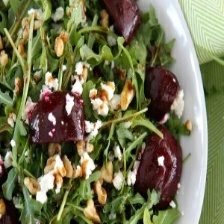

In [11]:
tf.keras.utils.array_to_img(x[0].numpy())